In [139]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.datasets import make_classification 
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time
%matplotlib inline

In [140]:
# Loading data
attendance_model_df = pd.read_csv("./Resources/attendance_condensed_demographic_location_model_data.csv")
attendance_model_df.head()

,year,month,member,zipcode,adult,teen,child,small_family_group,medium_family_group,large_family_group,maingroup_Davis,maingroup_Salt Lake County,maingroup_Utah County
0,2022,2,0,84129,1,0,0,0,0,0,0,1,0
1,2022,2,0,84129,0,1,0,0,0,0,0,1,0
2,2022,2,0,84129,0,0,0,0,0,0,0,1,0
3,2022,2,1,84010,0,0,0,0,0,0,1,0,0
4,2022,2,1,84010,0,0,0,0,0,0,1,0,0


In [141]:
# Define features set
X = attendance_model_df.copy()
X.drop("member", axis=1, inplace=True)
X.head()

,year,month,zipcode,adult,teen,child,small_family_group,medium_family_group,large_family_group,maingroup_Davis,maingroup_Salt Lake County,maingroup_Utah County
0,2022,2,84129,1,0,0,0,0,0,0,1,0
1,2022,2,84129,0,1,0,0,0,0,0,1,0
2,2022,2,84129,0,0,0,0,0,0,0,1,0
3,2022,2,84010,0,0,0,0,0,0,1,0,0
4,2022,2,84010,0,0,0,0,0,0,1,0,0


In [142]:
# Define target vector
y = attendance_model_df["member"].ravel()
y[:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [143]:
# define dataset for model. Full dataset = 606729, with target variable ('member' = 1) = 235697. 20%-30% of this subset = 47,139 - 70709
x, y = make_classification(n_samples=50000) 
smote = SMOTE() 
x_smote, y_smote = smote.fit_resample(x, y) 
  
# print the features and the labels 
print('x_smote:\n', x_smote) 
print('y_smote:\n', y_smote) 

x_smote:
 [[ 0.35017461  1.47582042  1.6415915  ... -1.07673155  0.8815426
   1.29981726]
 [-1.90281328 -1.72973882  0.32858194 ... -1.03656328 -1.43302244
   0.85229207]
 [ 0.61728625  1.66593621 -0.18671057 ... -1.2842359   0.37507751
  -0.60808104]
 ...
 [ 2.85369049 -0.98478378  0.74973984 ...  0.70905461  1.22584378
  -0.98078192]
 [-0.49489084 -0.74006668 -0.49009724 ...  0.17285544 -0.38873912
   0.90014696]
 [ 0.73064389 -1.11788316 -0.64154555 ... -0.11847348  1.67196142
   0.60109266]]
y_smote:
 [0 0 1 ... 0 0 0]


In [144]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, random_state=24)

In [145]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [146]:
# Fitting the Random Forest Model
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=13, max_depth=5, min_samples_split=4, min_samples_leaf=5, random_state=24)

In [147]:
# Fitting the model
start_time = time.time()

rf_model = rf_model.fit(X_train_scaled, y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  3.4358561038970947


In [154]:
# Making Predictions Using the testing data and the Random Forest Model
predictions = rf_model.predict(X_test_scaled)

In [155]:
# Model Evaluation
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

In [156]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5824,404
Actual 1,617,5658


Accuracy Score : 0.9183395984963608
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6228
           1       0.93      0.90      0.92      6275

    accuracy                           0.92     12503
   macro avg       0.92      0.92      0.92     12503
weighted avg       0.92      0.92      0.92     12503



In [157]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [158]:
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.2641602862599794, 'maingroup_Utah County'),
 (0.08339645602019101, 'small_family_group'),
 (0.0006802548538177751, 'adult'),
 (0.00041263191423116007, 'month'),
 (0.0003427479049875059, 'medium_family_group'),
 (0.0003157823765166978, 'child'),
 (0.00031006025050589063, 'year'),
 (0.00030484898125281694, 'zipcode'),
 (0.0002862559305577717, 'teen'),
 (0.0002652321216581335, 'maingroup_Davis')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

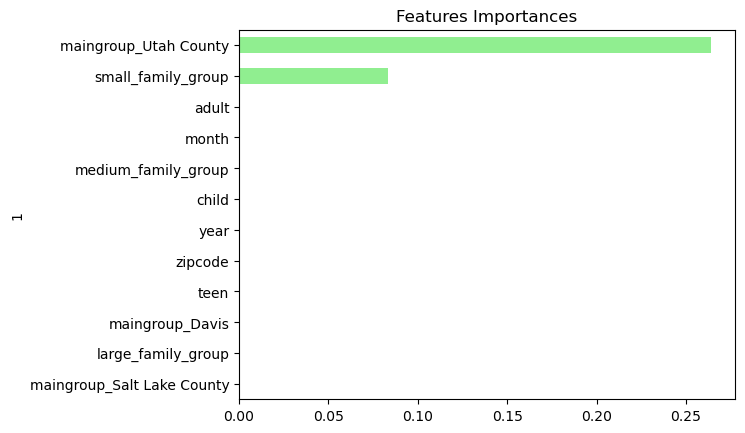

In [159]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)